# Read Data Sets

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

C:\Users\MERCER\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



# Read all train datasets

In [2]:
train_data = pd.read_csv("Train/train.csv")
view_log_train = pd.read_csv("Train/view_log.csv")
item_data = pd.read_csv("Train/item_data.csv")

In [3]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [4]:
view_log_train.head(3)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855


In [5]:
item_data.head(3)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619


In [6]:
train_data.shape,view_log_train.shape,item_data.shape

((237609, 7), (3118622, 5), (132761, 6))

In [7]:
# check null values
train_data.isnull().any().any(),view_log_train.isnull().any().any(),item_data.isnull().any().any()

(False, False, False)

In [8]:
item_data.duplicated(subset ='item_id' ).sum(),train_data.duplicated(subset ='impression_id' ).sum()

(0, 0)

In [9]:
test_data = pd.read_csv("Test/test.csv")
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1


In [10]:
test_data.shape

(90675, 6)

# Copy  Train _ Test Data

## Hypothesis

* There will be an increase in the traffic as the time pass by.

* The traffic will be high in December.

* Traffic on weekends/holidays will be more as compared to weekdays.

* Traffic during the night will be high.



In [11]:
train_original=train_data.copy() 
test_original=test_data.copy()

In [12]:
# Let’s dive deeper and have a look at the dataset. First of all let’s have a look at the features in the train and test dataset.

train_data.columns, train_data.columns


(Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
        'is_4G', 'is_click'],
       dtype='object'),
 Index(['impression_id', 'impression_time', 'user_id', 'app_code', 'os_version',
        'is_4G', 'is_click'],
       dtype='object'))

In [13]:
# Let’s look at the data types of each feature.

train_data.dtypes, test_data.dtypes

(impression_id      object
 impression_time    object
 user_id             int64
 app_code            int64
 os_version         object
 is_4G               int64
 is_click            int64
 dtype: object, impression_id      object
 impression_time    object
 user_id             int64
 app_code            int64
 os_version         object
 is_4G               int64
 dtype: object)

In [14]:
# dateTime is object so convert it in datetime
from datetime import datetime 
train_data['impression_time'] = pd.to_datetime(train_data.impression_time,format='%Y-%m-%d %H:%M:%S') 
test_data['impression_time'] = pd.to_datetime(test_data.impression_time,format='%Y-%m-%d %H:%M:%S')
test_original['impression_time'] = pd.to_datetime(test_original.impression_time,format='%Y-%m-%d %H:%M:%S') 
train_original['impression_time'] = pd.to_datetime(train_original.impression_time,format='%Y-%m-%d %H:%M:%S')

In [15]:
# Let’s look at the data types of each feature.

train_data.dtypes, test_data.dtypes

(impression_id              object
 impression_time    datetime64[ns]
 user_id                     int64
 app_code                    int64
 os_version                 object
 is_4G                       int64
 is_click                    int64
 dtype: object, impression_id              object
 impression_time    datetime64[ns]
 user_id                     int64
 app_code                    int64
 os_version                 object
 is_4G                       int64
 dtype: object)

In [16]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0


In [17]:
# We made some hypothesis for the effect of hour, day, month and year on the passenger count. So, let’s extract the year, month, day and hour from the Datetime to validate our hypothesis.

for i in (train_data, test_data, test_original, train_original):
    i['year']=i.impression_time.dt.year 
    i['month']=i.impression_time.dt.month 
    i['day']=i.impression_time.dt.day
    i['Hour']=i.impression_time.dt.hour
    i['min'] = i.impression_time.dt.minute

We made a hypothesis for the traffic pattern on weekday and weekend as well. So, let’s make a weekend variable to visualize the impact of weekend on traffic.

We will first extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.

Values of 5 and 6 represents that the days are weekend.



In [18]:
train_data['day of week']=train_data['impression_time'].dt.dayofweek 
temp = train_data['impression_time']

# Test


test_data['day of week']=test_data['impression_time'].dt.dayofweek 
temp = test_data['impression_time']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [19]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train_data['impression_time'].apply(applyer) 
train_data['weekend']=temp2

temp2 = test_data['impression_time'].apply(applyer) 
test_data['weekend']=temp2


In [20]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


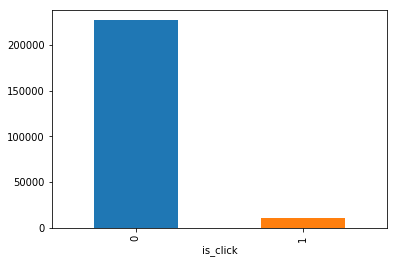

In [21]:
train_data.groupby("is_click")['impression_id'].count().plot.bar()

In [22]:
train_data['is_click'].value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [23]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


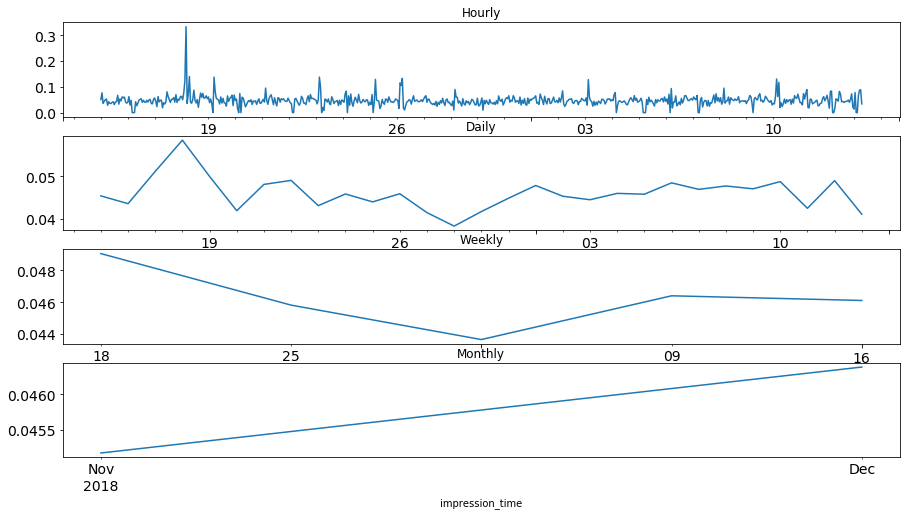

In [24]:
train_data.Timestamp = pd.to_datetime(train_data.impression_time,format='%Y-%m-%d %H:%M') 
train_data.index = train_data.Timestamp 
# Hourly time series 
hourly = train_data.resample('H').mean() 
# Converting to daily mean 
daily = train_data.resample('D').mean() 
# Converting to weekly mean 
weekly = train_data.resample('W').mean() 
# Converting to monthly mean 
monthly = train_data.resample('M').mean()
# Let’s look at the hourly, daily, weekly and monthly time series.

fig, axs = plt.subplots(4,1) 
hourly.is_click.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 
daily.is_click.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1]) 
weekly.is_click.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 
monthly.is_click.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3]) 

plt.show()

In [25]:
test_data.Timestamp = pd.to_datetime(test_data.impression_time,format='%Y-%m-%d %H:%M') 
test_data.index = test_data.Timestamp 
# Hourly time series 
hourly = test_data.resample('H').mean() 
# Converting to daily mean 
daily = test_data.resample('D').mean() 
# Converting to weekly mean 
weekly = test_data.resample('W').mean() 
# Converting to monthly mean 
monthly = test_data.resample('M').mean()


In [26]:
train_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,,,,,,
2018-11-15 00:00:00,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,2018,11,15,0,0,3,0
2018-11-15 00:01:00,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,2018,11,15,0,1,3,0
2018-11-15 00:02:00,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2018,11,15,0,2,3,0


In [27]:
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,,,,,
2018-12-13 07:44:00,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018,12,13,7,44,3,0
2018-12-13 07:45:00,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018,12,13,7,45,3,0
2018-12-13 07:46:00,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,2018,12,13,7,46,3,0


In [28]:
train_data.shape,test_data.shape

((237609, 14), (90675, 13))

In [29]:
Train=train_data.ix[0:190089]
valid=train_data.ix[190089:237610]

print("Shape Of Train",Train.shape)
print("Shape Of Valid",valid.shape)

Shape Of Train (190089, 14)
Shape Of Valid (47520, 14)


In [30]:
y_train = Train["is_click"] 
Train.drop(['is_click'], axis=1, inplace=True)
Train.drop(['impression_id'], axis=1, inplace=True)
Train.drop(['impression_time'], axis=1, inplace=True)
Train.drop(['user_id'], axis=1, inplace=True)
Train.drop(['os_version'], axis=1, inplace=True)
x_train = Train

y_valid = valid["is_click"] 
valid.drop(['is_click'], axis=1, inplace=True)
valid.drop(['impression_id'], axis=1, inplace=True)
valid.drop(['impression_time'], axis=1, inplace=True)
valid.drop(['user_id'], axis=1, inplace=True)
valid.drop(['os_version'], axis=1, inplace=True)
x_valid = valid



In [31]:
print('Shape of train & target',x_train.shape,y_train.shape)
print('Shape of valid & target',x_valid.shape,y_valid.shape)
print('Shape of yest & target',test_data.shape)


Shape of train & target (190089, 9) (190089,)
Shape of valid & target (47520, 9) (47520,)
Shape of yest & target (90675, 13)


In [32]:
x_train.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,
2018-11-15 00:00:00,422,0,2018,11,15,0,0,3,0
2018-11-15 00:01:00,467,1,2018,11,15,0,1,3,0
2018-11-15 00:02:00,259,1,2018,11,15,0,2,3,0


In [33]:
x_valid.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,
2018-12-04 18:48:00,127,1,2018,12,4,18,48,1,0
2018-12-04 18:49:00,127,1,2018,12,4,18,49,1,0
2018-12-04 18:50:00,37,1,2018,12,4,18,50,1,0


# Light GBM

In [38]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
param1 = {'n_estimators':  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50] ,
             'max_depth' :  [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50]}


estimator1 = LGBMClassifier(objective = "binary" ,eval_metric= 'auc',class_weight = "balanced")
Rsearch1= GridSearchCV(estimator1,param_grid=param1,scoring='roc_auc',n_jobs=8,  cv=10,verbose=21)
Rsearch1.fit(x_train,y_train)
Rsearch1.best_params_, Rsearch1.best_score_

Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done  15 tasks      | elapsed:    2.0s
[Parallel(

[Parallel(n_jobs=8)]: Done 136 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 137 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 138 tasks      | elapsed:   18.7s
[Parallel(n_jobs=8)]: Done 139 tasks      | elapsed:   18.8s
[Parallel(n_jobs=8)]: Done 140 tasks      | elapsed:   18.9s
[Parallel(n_jobs=8)]: Done 141 tasks      | elapsed:   19.2s
[Parallel(n_jobs=8)]: Done 142 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 143 tasks      | elapsed:   19.4s
[Parallel(n_jobs=8)]: Done 144 tasks      | elapsed:   19.7s
[Parallel(n_jobs=8)]: Done 145 tasks      | elapsed:   19.7s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   20.0s
[Parallel(n_jobs=8)]: Done 147 tasks      | elapsed:   20.1s
[Parallel(n_jobs=8)]: Done 148 tasks      | elapsed:   20.1s
[Parallel(n_jobs=8)]: Done 149 tasks      | elapsed:   20.5s
[Parallel(n_jobs=8)]: Done 150 tasks      | elapsed:   20.6s
[Parallel(n_jobs=8)]: Done 151 tasks      | elapsed:   20.7s
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 271 tasks      | elapsed:   40.4s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 273 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 274 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 275 tasks      | elapsed:   40.5s
[Parallel(n_jobs=8)]: Done 276 tasks      | elapsed:   41.0s
[Parallel(n_jobs=8)]: Done 277 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done 278 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done 279 tasks      | elapsed:   41.5s
[Parallel(n_jobs=8)]: Done 280 tasks      | elapsed:   41.5s
[Parallel(n_jobs=8)]: Done 281 tasks      | elapsed:   41.6s
[Parallel(n_jobs=8)]: Done 282 tasks      | elapsed:   41.7s
[Parallel(n_jobs=8)]: Done 283 tasks      | elapsed:   41.7s
[Parallel(n_jobs=8)]: Done 284 tasks      | elapsed:   42.3s
[Parallel(n_jobs=8)]: Done 285 tasks      | elapsed:   42.5s
[Parallel(n_jobs=8)]: Done 286 tasks      | elapsed:   42.6s
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 406 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 407 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 408 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 409 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 410 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 411 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 412 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 413 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 414 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 415 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 416 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 417 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 418 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 419 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 420 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 421 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 541 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 542 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 543 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 544 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 545 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 546 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 547 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 548 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 549 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 550 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 551 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 552 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 553 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 554 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 555 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 556 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 678 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 679 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 680 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 681 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 682 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 683 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 684 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 685 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 686 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 687 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 688 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 689 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 690 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 691 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 692 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 693 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 814 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 815 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 816 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 817 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 818 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 819 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 820 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 821 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 822 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 823 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 824 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 825 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 826 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 827 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 828 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 829 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 949 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 950 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 951 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 952 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 953 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 954 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 955 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 956 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 957 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 958 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 959 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 960 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 961 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 962 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 963 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Done 964 tasks      | elapsed:  2.9min
[Parallel(n_jobs=8)]: Do

[Parallel(n_jobs=8)]: Done 1082 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1083 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1084 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1085 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1086 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1087 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1088 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1089 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1090 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1091 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1092 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1093 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1094 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1095 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1096 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 1097 tasks      | elapsed:  3.3min
[Paralle

[Parallel(n_jobs=8)]: Done 1215 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1216 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1217 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1218 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1219 tasks      | elapsed:  3.7min
[Parallel(n_jobs=8)]: Done 1220 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1221 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1222 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1223 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1224 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1225 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1226 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1227 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1228 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1229 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 1230 tasks      | elapsed:  3.8min
[Paralle

[Parallel(n_jobs=8)]: Done 1348 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1349 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1350 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1351 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1352 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1353 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1354 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1355 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1356 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1357 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1358 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1359 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1360 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1361 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1362 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 1363 tasks      | elapsed:  4.2min
[Paralle

[Parallel(n_jobs=8)]: Done 1481 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1482 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1483 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1484 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1485 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1486 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1487 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 1488 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1489 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1490 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1491 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1492 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1493 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1494 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1495 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 1496 tasks      | elapsed:  4.7min
[Paralle

[Parallel(n_jobs=8)]: Done 1615 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1616 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1617 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1618 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1619 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1620 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1621 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1622 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1623 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1624 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1625 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1626 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1627 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1628 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1629 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 1630 tasks      | elapsed:  5.1min
[Paralle

[Parallel(n_jobs=8)]: Done 1749 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1750 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1751 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1752 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1753 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1754 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1755 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1756 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1757 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1758 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 1759 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1760 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1761 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1762 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1763 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 1764 tasks      | elapsed:  5.6min
[Paralle

[Parallel(n_jobs=8)]: Done 1884 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1885 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1886 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1887 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1888 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1889 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1890 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1891 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1892 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1893 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1894 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1895 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1896 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1897 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1898 tasks      | elapsed:  6.0min
[Parallel(n_jobs=8)]: Done 1899 tasks      | elapsed:  6.0min
[Paralle

[Parallel(n_jobs=8)]: Done 2018 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2019 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2020 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2021 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2022 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2023 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2024 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2025 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2026 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2027 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2028 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2029 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 2030 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 2031 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 2032 tasks      | elapsed:  6.5min
[Parallel(n_jobs=8)]: Done 2033 tasks      | elapsed:  6.5min
[Paralle

[Parallel(n_jobs=8)]: Done 2152 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2153 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2154 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2155 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2156 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2157 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2158 tasks      | elapsed:  6.8min
[Parallel(n_jobs=8)]: Done 2159 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2160 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2161 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2162 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2163 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2164 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2165 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2166 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done 2167 tasks      | elapsed:  6.9min
[Paralle

[Parallel(n_jobs=8)]: Done 2285 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2286 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2287 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2288 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2289 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2290 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2291 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2292 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2293 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2294 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2295 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2296 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2297 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2298 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2299 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 2300 tasks      | elapsed:  7.3min
[Paralle

[Parallel(n_jobs=8)]: Done 2418 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 2419 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 2420 tasks      | elapsed:  7.7min
[Parallel(n_jobs=8)]: Done 2421 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2422 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2423 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2424 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2425 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2426 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2427 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2428 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2429 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2430 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2431 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2432 tasks      | elapsed:  7.8min
[Parallel(n_jobs=8)]: Done 2433 tasks      | elapsed:  7.8min
[Paralle

[Parallel(n_jobs=8)]: Done 2551 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2552 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2553 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2554 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2555 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2556 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2557 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2558 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2559 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2560 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2561 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2562 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2563 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2564 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2565 tasks      | elapsed:  8.2min
[Parallel(n_jobs=8)]: Done 2566 tasks      | elapsed:  8.2min
[Paralle

[Parallel(n_jobs=8)]: Done 2684 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2685 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2686 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2687 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2688 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2689 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2690 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2691 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2692 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2693 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2694 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2695 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2696 tasks      | elapsed:  8.6min
[Parallel(n_jobs=8)]: Done 2697 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 2698 tasks      | elapsed:  8.7min
[Parallel(n_jobs=8)]: Done 2699 tasks      | elapsed:  8.7min
[Paralle

[Parallel(n_jobs=8)]: Done 2817 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2818 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2819 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2820 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2821 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2822 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2823 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2824 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2825 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2826 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2827 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2828 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2829 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2830 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2831 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done 2832 tasks      | elapsed:  9.1min
[Paralle

[Parallel(n_jobs=8)]: Done 2951 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2952 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2953 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2954 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2955 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2956 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2957 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2958 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2959 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2960 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2961 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2962 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2963 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2964 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2965 tasks      | elapsed:  9.5min
[Parallel(n_jobs=8)]: Done 2966 tasks      | elapsed:  9.6min
[Paralle

[Parallel(n_jobs=8)]: Done 3084 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3085 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3086 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3087 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3088 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3089 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3090 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3091 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3092 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3093 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3094 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3095 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3096 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3097 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3098 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 3099 tasks      | elapsed:  9.9min
[Paralle

[Parallel(n_jobs=8)]: Done 3218 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 3219 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 3220 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 3221 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3222 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3223 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3224 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3225 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3226 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3227 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3228 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3229 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3230 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3231 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3232 tasks      | elapsed: 10.8min
[Parallel(n_jobs=8)]: Done 3233 tasks      | elapsed: 10.8min
[Paralle

[Parallel(n_jobs=8)]: Done 3353 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3354 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3355 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3356 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3357 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3358 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3359 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3360 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3361 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3362 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3363 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3364 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3365 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3366 tasks      | elapsed: 11.4min
[Parallel(n_jobs=8)]: Done 3367 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 3368 tasks      | elapsed: 11.5min
[Paralle

[Parallel(n_jobs=8)]: Done 3486 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3487 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3488 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3489 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3490 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3491 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3492 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3493 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3494 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3495 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3496 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3497 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3498 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3499 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3500 tasks      | elapsed: 12.0min
[Parallel(n_jobs=8)]: Done 3501 tasks      | elapsed: 12.0min
[Paralle

[Parallel(n_jobs=8)]: Done 3620 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3621 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3622 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3623 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3624 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3625 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3626 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3627 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3628 tasks      | elapsed: 12.6min
[Parallel(n_jobs=8)]: Done 3629 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3630 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3631 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3632 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3633 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3634 tasks      | elapsed: 12.7min
[Parallel(n_jobs=8)]: Done 3635 tasks      | elapsed: 12.7min
[Paralle

[Parallel(n_jobs=8)]: Done 3753 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3754 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3755 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3756 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3757 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3758 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3759 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3760 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3761 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3762 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3763 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3764 tasks      | elapsed: 13.2min
[Parallel(n_jobs=8)]: Done 3765 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 3766 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 3767 tasks      | elapsed: 13.3min
[Parallel(n_jobs=8)]: Done 3768 tasks      | elapsed: 13.3min
[Paralle

[Parallel(n_jobs=8)]: Done 3887 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3888 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3889 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3890 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3891 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3892 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3893 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3894 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3895 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3896 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3897 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3898 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3899 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3900 tasks      | elapsed: 13.8min
[Parallel(n_jobs=8)]: Done 3901 tasks      | elapsed: 13.9min
[Parallel(n_jobs=8)]: Done 3902 tasks      | elapsed: 13.9min
[Paralle

({'max_depth': 9, 'n_estimators': 14}, 0.6826680488452725)

In [39]:
n1=Rsearch1.best_params_["n_estimators"]
d1=Rsearch1.best_params_['max_depth']

In [40]:
n1,d1

(14, 9)

In [43]:
param2 = {'reg_lambda':  [0.05,0.01,0.5,0.1,0,1,2,5] ,
             'reg_alpha' :  [0.05,0.5,0,1,2,5,8,10,15]}


estimator2 = LGBMClassifier(objective = "binary" ,eval_metric= 'auc',class_weight = "balanced",n_estimators = n1,max_depth = d1)
Rsearch2 = GridSearchCV(estimator2,param_grid=param2,scoring='roc_auc',n_jobs=10,  cv=10,verbose=21)
Rsearch2.fit(x_train,y_train)
Rsearch2.best_params_, Rsearch2.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=10)]: Done 133 tasks      | elapsed:   35.5s
[Parallel(n_jobs=10)]: Done 134 tasks      | elapsed:   36.0s
[Parallel(n_jobs=10)]: Done 135 tasks      | elapsed:   36.4s
[Parallel(n_jobs=10)]: Done 136 tasks      | elapsed:   36.5s
[Parallel(n_jobs=10)]: Done 137 tasks      | elapsed:   36.5s
[Parallel(n_jobs=10)]: Done 138 tasks      | elapsed:   36.6s
[Parallel(n_jobs=10)]: Done 139 tasks      | elapsed:   36.6s
[Parallel(n_jobs=10)]: Done 140 tasks      | elapsed:   37.8s
[Parallel(n_jobs=10)]: Done 141 tasks      | elapsed:   37.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   38.0s
[Parallel(n_jobs=10)]: Done 143 tasks      | elapsed:   38.1s
[Parallel(n_jobs=10)]: Done 144 tasks      | elapsed:   38.6s
[Parallel(n_jobs=10)]: Done 145 tasks      | elapsed:   39.1s
[Parallel(n_jobs=10)]: Done 146 tasks      | elapsed:   39.1s
[Parallel(n_jobs=10)]: Done 147 tasks      | elapsed:   39.2s
[Parallel(n_jobs=10)]: Done 148 tasks      | elapsed:   39.3s
[Paralle

[Parallel(n_jobs=10)]: Done 267 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 269 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 270 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 271 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 273 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 274 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 275 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 276 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 277 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 279 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 280 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 281 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 282 tasks      | elapsed:  1.2min
[Paralle

[Parallel(n_jobs=10)]: Done 402 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 403 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 404 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 405 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 406 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 407 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 408 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 409 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 410 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 411 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 412 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 413 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 414 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 415 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 416 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 417 tasks      | elapsed:  1.8min
[Paralle

[Parallel(n_jobs=10)]: Done 535 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 536 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 537 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 538 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 539 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 540 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 541 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 542 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 543 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 544 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 545 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 546 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 547 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 548 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 549 tasks      | elapsed:  2.3min
[Parallel(n_jobs=10)]: Done 550 tasks      | elapsed:  2.3min
[Paralle

[Parallel(n_jobs=10)]: Done 669 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 671 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 673 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 674 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 675 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 676 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 677 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 678 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 679 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 680 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 681 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 682 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 683 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done 684 tasks      | elapsed:  2.9min
[Paralle

({'reg_alpha': 5, 'reg_lambda': 0.01}, 0.6830109640733575)

In [46]:
lamda1 = Rsearch2.best_params_["reg_lambda"]
alpha1 = Rsearch2.best_params_['reg_alpha']

In [47]:
from sklearn.model_selection import GridSearchCV

param3 = {'learning_rate':  [0.005,0.05,0.5,0.01,0.1,1] 
             }


estimator3 = LGBMClassifier(objective = "binary" ,eval_metric= 'auc',class_weight = "balanced",n_estimators = n1,max_depth = d1,reg_lambda = lamda1,reg_alpha = alpha1)
Rsearch3 = GridSearchCV(estimator3,param_grid = param3,scoring='roc_auc',n_jobs=10,  cv=10,verbose=21)
Rsearch3.fit(x_train,y_train)
Rsearch3.best_params_, Rsearch3.best_score_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done   6 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done  11 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  13 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=10)]: Done  15 tasks      | elapsed:  

({'learning_rate': 0.1}, 0.6830109640733575)

In [48]:
l1 = Rsearch3.best_params_["learning_rate"]

In [49]:
estimator_bow = LGBMClassifier(objective= 'binary',
eval_metric= 'auc',max_depth=d1,n_estimators=n1,learning_rate = l1,reg_lambda = lamda1,reg_alpha = alpha1)

estimator_bow.fit(x_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='auc', importance_type='split', learning_rate=0.1,
        max_depth=9, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=14, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=5,
        reg_lambda=0.01, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

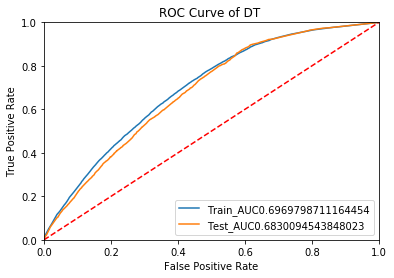

In [51]:
from  sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


score_roc_train = estimator_bow.predict_proba(x_train)
fpr_train, tpr_train, threshold_train = roc_curve(y_train, score_roc_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)

score_roc_test = estimator_bow.predict_proba(x_valid)
fpr_test, tpr_test, threshold_test = roc_curve(y_valid, score_roc_test[:,1])
roc_auc_test = auc(fpr_test, tpr_test)


plt.plot(fpr_train, tpr_train, label = "Train_AUC"+str(auc(fpr_train, tpr_train)))
plt.plot(fpr_test, tpr_test, label = "Test_AUC"+str(auc(fpr_test, tpr_test)))
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of DT ')
plt.show()


In [53]:
y_train_pred =  estimator_bow.predict(x_train)

y_test_pred =  estimator_bow.predict(x_valid)

In [56]:
test_data.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,,,,,
2018-12-13 07:44:00,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018,12,13,7,44,3,0
2018-12-13 07:45:00,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018,12,13,7,45,3,0
2018-12-13 07:46:00,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,2018,12,13,7,46,3,0


In [57]:

test_data.drop(['impression_id'], axis=1, inplace=True)
test_data.drop(['impression_time'], axis=1, inplace=True)
test_data.drop(['user_id'], axis=1, inplace=True)
test_data.drop(['os_version'], axis=1, inplace=True)



In [58]:
test_data.head(3)

,app_code,is_4G,year,month,day,Hour,min,day of week,weekend
impression_time,,,,,,,,,
2018-12-13 07:44:00,127,1,2018,12,13,7,44,3,0
2018-12-13 07:45:00,44,0,2018,12,13,7,45,3,0
2018-12-13 07:46:00,296,1,2018,12,13,7,46,3,0


In [67]:
y_test_pred =  estimator_bow.predict_proba(test_data)


In [68]:
test_original.head(3)

,impression_id,impression_time,user_id,app_code,os_version,is_4G,year,month,day,Hour,min
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1,2018,12,13,7,44
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0,2018,12,13,7,45
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1,2018,12,13,7,46


In [73]:
len(y_test_pred)

90675

In [74]:
test_original.shape

(90675, 11)

In [ ]:
preddf['is_click'].value_counts()

In [78]:


# Get IDs and predictions
predids=test_original['impression_id']
y_id=predids.values.tolist()
preddf=pd.DataFrame({'impression_id':y_id,
                     'is_click':y_test_pred[:,1]})

#look at predictions
preddf.head(3)




,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.052167
1,caac14a5bf2ba283db7708bb34855760,0.019708
2,13f10ba306a19ce7bec2f3cae507b698,0.067156


In [80]:
# SAVE DF
preddf.to_csv('submission_LGBM2.csv',index=False)

